### Installations

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

import torch
print("Available GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

Available GPUs: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3090


In [2]:
# !nvidia-smi -L
# !pip install -q jax flax optax ml_collections 

### Optional: Load Google drive and change directory to neurips_2023_demo

In [3]:
import sys

if "google.colab" in sys.modules:
    print("Running on Google Colab")

    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/neurips_2023_15410/

### Load libraries

Requirements: data_utils_pytorch, model_utils, train_mse_utils / train_xent_utils in the current directory

In [4]:
loss = 'mse'
# custom modules
import data_utils_pytorch
import model_utils as models

if loss == 'mse':
    import train_mse_utils as train_utils
elif loss == 'xent':
    import train_xent_utils as train_utils
else:
    print('Unsupported loss function')
    raise


# in use imports
import jax
from jax import numpy as jnp
import optax
from ml_collections import config_dict

#usual imports
import numpy as np
import pandas as pd
from sys import argv
import gc
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import seaborn as sns

### Helper functions

In [5]:
def poly(coeffs, x):
    "Given polynomial coefficients coeffs, evaluates the polynomal f(x)"
    degree = len(coeffs)-1
    output = 0
    for i in range(len(coeffs)):
        output += coeffs[i] * x**(degree-i)
    return output

pandas helper functions

In [6]:
def get_rows_where_col_equals(df, col, value):
	return df.loc[df[col] == value].copy()
 
def get_rows_where_col_in(df, col, values):
	return df.loc[df[col].isin(values)].copy()

def get_rows_where_col_greater(df, col, value):
	return df.loc[df[col] > value].copy()

def get_rows_where_col_less(df, col, value):
	return df.loc[df[col] < value].copy()

### Model definition

In this demo, we will use a 8 layer ReLU FCN to obtain the phase diagram of early training. The model can be changed to Myrtle CNNs, ResNets or linear FCNs using the model_util.py

In [7]:
def create_train_state(config, batches):
    """
    Description: Creates a Flax train state with learning rate eta = c / sharpness init
    Input: 
        1. config: ml_collections dict which contains the model and optimizer hyperparameters
        2. batches: batches used for sharpness estimation
    Output:
        1. state: Flax state with learning rate eta = c / sharpness init
        2. sharpness_init: sharpness at initialization
    """

    #create model
    model = models.Myrtle(num_filters=config.width,
    num_layers=config.depth,
    num_classes=config.num_classes,
    use_bias=config.use_bias,
    varw=config.varw
    )

    #initialize the parameters
    example = jax.random.normal(config.init_rng, shape = config.in_dim)
    init_params = model.init(config.init_rng, example)['params'] #initialize parameters

    #create a dummy state and optimizer for sharpness calculation
    _opt = optax.sgd(learning_rate = 0.1, momentum = config.momentum)
    _state = train_utils.TrainState.create(apply_fn = model.apply, params = init_params, opt = _opt)

    #calculate hessian and learning rate
    sharpness_init = train_utils.estimate_hessian(_state, batches, num_batches = config.measure_batches, power_iterations = config.power_iterations)
    lr_rate = config.lr_const/sharpness_init

    # create a new state with learning rate lr_rate; 
    # updating learning rate does not work since the recemt flax update
    opt = optax.sgd(learning_rate = lr_rate, momentum = config.momentum)
    state = train_utils.TrainState.create(apply_fn = model.apply, params = init_params, opt = opt)
    return state, sharpness_init

### Training loop

In [8]:
def train_and_evaluate(config, train_ds):
    """
    Description: Creates a training state and trains for 10 steps
    Input: 
        1. config: ml_collections dictionary containing all the hyperparameters
        2. train_ds: tuple (x_train, y_train) of the training data
    Output: 
        1. Divergence: bool; Flag for training divergence
        2. train_results: np array containing training loss, sharpness and accuracy trajectories
    """

    train_results = list()

    #create train and validation batches using rng
    rng = config.sgd_rng
    # create train and test batches for measurements: measure batches are called train_batches and val_batches; training batches are called batches
    train_batches = data_utils_pytorch.data_stream(rng, train_ds, config.measure_examples)

    #create model
    state, sharpness_init = create_train_state(config, train_batches)
    init_params = state.params

    #print(f'Top Hessian init: {sharpness_init:0.4f}, Learning rate: {config.lr_const/sharpness_init:0.4f}')

    #measure metrics at initialization
    train_loss_init, train_acc_init = train_utils.measure_state(state, train_batches, config.num_train, config.measure_examples)

    #store results at init
    result_init = jnp.asarray([0, 0, train_loss_init, train_loss_init, train_acc_init, sharpness_init, sharpness_init])
    train_results.append(result_init)
    print(f'{0}, {0}, {train_loss_init:0.4f}, {train_acc_init:0.4f}, {sharpness_init:0.4f}, {sharpness_init:0.4f}')

    divergence = False

    for epoch in range(config.num_epochs):

        rng, _ = jax.random.split(rng)
        batches = data_utils_pytorch.data_stream(rng, train_ds, config.batch_size)

        for batch_ix in range(config.num_steps):
            #get the next batch and calculate the step
            batch = next(batches)
            x, y = batch
            step = config.num_batches*epoch + batch_ix
            
            #compute gradient and other metrics and update the model
            state, loss_batch = train_utils.train_batch(state, batch)

            # hard cut-off on loss divergence; catapult loss is at most of O(width); max width in this experiment is 2048
            if loss_batch > 10**5: 
                divergence = True
                break

            # evaluate training loss, accuracy and sharpness at step t            
            train_loss_step, train_acc_step = train_utils.measure_state(state, train_batches, config.num_train, config.measure_examples)
            sharpness_step = train_utils.estimate_hessian(state, batches, num_batches = config.measure_batches, power_iterations = config.power_iterations)
    
            #store results
            result_step = jnp.asarray([step+1, epoch+1, train_loss_step, train_loss_init, train_acc_step, sharpness_step, sharpness_init])
            train_results.append(result_step)
            print(f'{step+1}, {epoch+1}, {train_loss_step:0.4f}, {train_acc_step:0.4f}, {sharpness_step:0.4f}, {sharpness_init:0.4f}')
    
    del state
    train_results = jnp.asarray(train_results)
    train_results = jax.device_get(train_results)
    return divergence, train_results


### Hyperparameters

In [9]:
dataset = 'cifar10'
num_classes = 10

train_ds, test_ds, info = data_utils_pytorch.load_data_pytorch(dataset, num_classes)

#Hyperparameters
config = config_dict.ConfigDict()
config.num_train, config.num_test = info.num_train, info.num_test

config.act = 'relu'
config.model = f'fc_{config.act}'
config.use_bias = False 
config.varw = 2.0 # this is the variance of all but last layer
config.varwL = 1.0 # last layer variance

widths = [128, 256, 512]
config.depth = 10
config.in_dim = info.in_dim
config.num_classes = info.num_classes 

# batch size
config.batch_size = 128
# batch size for hessian measurement
config.measure_examples = 512
#number of batches for hessian measurement
config.measure_batches = 1

config.num_batches = data_utils_pytorch.estimate_num_batches(config.num_train, config.batch_size)

#number of power iterations
config.power_iterations = 20

#optimizer related hyperparameters
# Sample learning rates in powers of 2 starting with 2**0.0
lr_exp_start = jax.device_put(0.0)
lr_step = 0.2 # step size for increasing the learning rate
config.momentum = jax.device_put(0.0) # momentum for sgd
config.num_steps = 10 # train for ten steps
config.num_epochs = 1 # one epoch only

# averages
init_averages = 1 #number of initialization averages
sgd_runs = 1 # number of sgd runs for each initialization

Files already downloaded and verified


Files already downloaded and verified


(32, 32, 3) ================================


### Early time experiment:

* We will train a 8 layer ReLU FCN for 10 steps using MSE loss using SGD with learning rate $\eta = c / \lambda_0^H$ and batch size $B = 512$. Here, $\lambda_0^H$ is the sharpness at initialization. The same experiment can be performed with other architectures by replacing the model definition in the create_train_state function

* We will sample learning rate constants $c$ in powers of 2, i.e., $c = 2^x$ with $x$ incremented in steps of $0.1$. 

* We will start with $x = x_{min} = 0.0$, wich corresponds to $\eta = 1 / \lambda_0^H$, as we are interested in the catapult dynamics.

* To reduce computational time, we will run the experiment for only one random initialization.


Note: This experiment takes about 45 mins to run on a V100 with 16 GB RAM. 


In [10]:
# for storing trajectories
dfs = list()

#run for all widths
for width in widths:
    config.width = width
    #run for init_averages different initializations
    for iteration in range(1, init_averages+1):
        config.init_rng = jax.random.PRNGKey(iteration)
        #run for sgd_run different mini batch sequences
        for run in range(1, sgd_runs + 1):
            config.sgd_rng = jax.random.PRNGKey(run)
            lr_exp = lr_exp_start
            divergence = False

            while not divergence:
                config.lr_exp = lr_exp
                config.lr_const = 2**lr_exp
                print(f'w: {config.width}, d: {config.depth}, I: {iteration}, J: {run}, x: {lr_exp:0.1f}, B: {config.batch_size}, t: {config.num_steps}')

                divergence, train_results = train_and_evaluate(config, train_ds)

                if not divergence:
                    # append training results
                    df = pd.DataFrame(train_results, columns = ['step', 'epoch', 'train_loss_step', 'train_loss_init', 'train_accuracy', 'sharpness_step', 'sharpness_init'], dtype = float)
                    df['lr_exp'] = config.lr_exp; df['lr_const'] = config.lr_const; df['batch_size'] = config.batch_size; df['num_steps'] = config.num_epochs; df['I'] = iteration; df['J'] = run; df['width'] = config.width; df['depth'] = config.depth
                    dfs.append(df)
                    del df

                else:
                    print('Divergence')

                del train_results

                lr_exp += lr_step

                collected = gc.collect()
                #print("Garbage collector: collected %d objects." % (collected))

# concatenate results
dfs = pd.concat(dfs, axis = 0, ignore_index = True)


w: 128, d: 10, I: 1, J: 1, x: 0.0, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.1388, 0.0998, 46.0805, 157.9984


2, 1, 0.1080, 0.1003, 33.8529, 157.9984


3, 1, 0.0930, 0.1000, 27.5376, 157.9984


4, 1, 0.0825, 0.0997, 22.7108, 157.9984


5, 1, 0.0755, 0.0987, 20.7992, 157.9984


6, 1, 0.0705, 0.0970, 15.9358, 157.9984


7, 1, 0.0665, 0.0986, 16.3210, 157.9984


8, 1, 0.0635, 0.0988, 14.5001, 157.9984


9, 1, 0.0609, 0.0992, 14.5918, 157.9984


10, 1, 0.0589, 0.0998, 13.8657, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 0.2, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.1224, 0.0998, 38.0907, 157.9984


2, 1, 0.0982, 0.1005, 28.8106, 157.9984


3, 1, 0.0858, 0.0999, 23.6430, 157.9984


4, 1, 0.0769, 0.0992, 18.2713, 157.9984


5, 1, 0.0709, 0.0980, 15.9806, 157.9984


6, 1, 0.0666, 0.0978, 14.4803, 157.9984


7, 1, 0.0631, 0.0988, 15.1420, 157.9984


8, 1, 0.0605, 0.0989, 13.7385, 157.9984


9, 1, 0.0583, 0.0988, 13.8550, 157.9984


10, 1, 0.0565, 0.0997, 13.2186, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 0.4, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9985, 157.9985


1, 1, 0.1078, 0.0998, 30.8440, 157.9985


2, 1, 0.0895, 0.1003, 24.0218, 157.9985


3, 1, 0.0794, 0.0988, 18.0200, 157.9985


4, 1, 0.0721, 0.0988, 16.3132, 157.9985


5, 1, 0.0669, 0.0982, 14.5469, 157.9985


6, 1, 0.0632, 0.0984, 13.4632, 157.9985


7, 1, 0.0602, 0.0991, 14.0753, 157.9985


8, 1, 0.0579, 0.0995, 12.9562, 157.9985


9, 1, 0.0560, 0.0993, 13.2352, 157.9985


10, 1, 0.0545, 0.0998, 13.0321, 157.9985


w: 128, d: 10, I: 1, J: 1, x: 0.6, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0955, 0.1000, 24.4464, 157.9984


2, 1, 0.0819, 0.0992, 17.6542, 157.9984


3, 1, 0.0738, 0.0993, 15.3260, 157.9984


4, 1, 0.0678, 0.0988, 14.7440, 157.9984


5, 1, 0.0634, 0.0989, 13.3317, 157.9984


6, 1, 0.0603, 0.0983, 12.4679, 157.9984


7, 1, 0.0577, 0.0995, 13.0311, 157.9984


8, 1, 0.0557, 0.0993, 12.0754, 157.9984


9, 1, 0.0541, 0.0992, 12.8424, 157.9984


10, 1, 0.0528, 0.0995, 13.7900, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 0.8, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0856, 0.0994, 18.7464, 157.9984


2, 1, 0.0754, 0.0987, 15.5708, 157.9984


3, 1, 0.0689, 0.0985, 13.4885, 157.9984


4, 1, 0.0640, 0.0983, 13.3387, 157.9984


5, 1, 0.0604, 0.0991, 12.0887, 157.9984


6, 1, 0.0578, 0.0986, 11.4102, 157.9984


7, 1, 0.0556, 0.0993, 11.9366, 157.9984


8, 1, 0.0539, 0.0992, 11.1103, 157.9984


9, 1, 0.0525, 0.0997, 12.4303, 157.9984


10, 1, 0.0515, 0.0999, 13.7814, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 1.0, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0784, 0.0990, 17.6254, 157.9984


2, 1, 0.0701, 0.0974, 14.3398, 157.9984


3, 1, 0.0648, 0.0991, 12.1098, 157.9984


4, 1, 0.0608, 0.0988, 11.9433, 157.9984


5, 1, 0.0578, 0.0998, 10.8236, 157.9984


6, 1, 0.0556, 0.0994, 10.2546, 157.9984


7, 1, 0.0538, 0.0998, 10.7994, 157.9984


8, 1, 0.0524, 0.0991, 10.0799, 157.9984


9, 1, 0.0512, 0.0998, 11.9732, 157.9984


10, 1, 0.0504, 0.1000, 13.0421, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 1.2, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0735, 0.0986, 16.9181, 157.9984


2, 1, 0.0660, 0.0989, 13.3046, 157.9984


3, 1, 0.0614, 0.0993, 10.9345, 157.9984


4, 1, 0.0581, 0.0992, 10.6253, 157.9984


5, 1, 0.0556, 0.0999, 9.5616, 157.9984


6, 1, 0.0538, 0.0989, 9.0785, 157.9984


7, 1, 0.0523, 0.0999, 9.5606, 157.9984


8, 1, 0.0511, 0.0994, 8.9944, 157.9984


9, 1, 0.0501, 0.1001, 11.1254, 157.9984


10, 1, 0.0494, 0.0996, 11.8612, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 1.4, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9985, 157.9985


1, 1, 0.0707, 0.1003, 16.4328, 157.9985


2, 1, 0.0632, 0.0990, 12.3888, 157.9985


3, 1, 0.0590, 0.1000, 9.8437, 157.9985


4, 1, 0.0561, 0.1003, 9.3775, 157.9985


5, 1, 0.0539, 0.0997, 8.3234, 157.9985


6, 1, 0.0524, 0.0992, 7.9013, 157.9985


7, 1, 0.0511, 0.1000, 8.2798, 157.9985


8, 1, 0.0501, 0.0996, 7.8186, 157.9985


9, 1, 0.0493, 0.1002, 9.7845, 157.9985


10, 1, 0.0487, 0.1002, 10.3898, 157.9985


w: 128, d: 10, I: 1, J: 1, x: 1.6, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0695, 0.0999, 16.0752, 157.9984


2, 1, 0.0613, 0.1000, 11.4852, 157.9984


3, 1, 0.0572, 0.1001, 8.8584, 157.9984


4, 1, 0.0546, 0.0998, 8.2251, 157.9984


5, 1, 0.0526, 0.1002, 7.2143, 157.9984


6, 1, 0.0513, 0.0998, 6.7523, 157.9984


7, 1, 0.0502, 0.1003, 7.1448, 157.9984


8, 1, 0.0493, 0.0998, 6.6426, 157.9984


9, 1, 0.0486, 0.1004, 8.3014, 157.9984


10, 1, 0.0481, 0.0998, 8.7417, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 1.8, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0695, 0.1000, 15.8448, 157.9984


2, 1, 0.0602, 0.1002, 10.5884, 157.9984


3, 1, 0.0561, 0.0998, 7.9393, 157.9984


4, 1, 0.0537, 0.0998, 7.2159, 157.9984


5, 1, 0.0518, 0.0998, 6.1873, 157.9984


6, 1, 0.0506, 0.0994, 5.8752, 157.9984


7, 1, 0.0496, 0.1006, 6.1099, 157.9984


8, 1, 0.0488, 0.1005, 5.5588, 157.9984


9, 1, 0.0482, 0.1004, 6.8434, 157.9984


10, 1, 0.0478, 0.0997, 7.1196, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 2.0, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0702, 0.1000, 15.6785, 157.9984


2, 1, 0.0595, 0.0997, 9.7489, 157.9984


3, 1, 0.0554, 0.1003, 7.0611, 157.9984


4, 1, 0.0531, 0.1009, 6.2822, 157.9984


5, 1, 0.0513, 0.1005, 5.4217, 157.9984


6, 1, 0.0502, 0.0999, 5.1361, 157.9984


7, 1, 0.0493, 0.1003, 5.1725, 157.9984


8, 1, 0.0486, 0.1008, 4.7326, 157.9984


9, 1, 0.0480, 0.1004, 5.5909, 157.9984


10, 1, 0.0476, 0.1006, 5.7115, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 2.2, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9985, 157.9985


1, 1, 0.0711, 0.1000, 15.5125, 157.9985


2, 1, 0.0590, 0.0998, 8.9313, 157.9985


3, 1, 0.0549, 0.0997, 6.2723, 157.9985


4, 1, 0.0526, 0.1004, 5.5062, 157.9985


5, 1, 0.0510, 0.0999, 4.8088, 157.9985


6, 1, 0.0500, 0.0994, 4.4826, 157.9985


7, 1, 0.0492, 0.1004, 4.3798, 157.9985


8, 1, 0.0485, 0.1003, 4.0411, 157.9985


9, 1, 0.0479, 0.1003, 4.5734, 157.9985


10, 1, 0.0475, 0.1004, 4.6132, 157.9985


w: 128, d: 10, I: 1, J: 1, x: 2.4, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9985, 157.9985


1, 1, 0.0720, 0.1001, 15.3759, 157.9985


2, 1, 0.0585, 0.1000, 8.1399, 157.9985


3, 1, 0.0544, 0.0997, 5.6569, 157.9985


4, 1, 0.0522, 0.1000, 5.0179, 157.9985


5, 1, 0.0507, 0.0991, 4.3296, 157.9985


6, 1, 0.0497, 0.0996, 3.9615, 157.9985


7, 1, 0.0490, 0.1005, 3.8142, 157.9985


8, 1, 0.0483, 0.1005, 3.5288, 157.9985


9, 1, 0.0478, 0.1001, 3.9009, 157.9985


10, 1, 0.0475, 0.0998, 3.8944, 157.9985


w: 128, d: 10, I: 1, J: 1, x: 2.6, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9985, 157.9985


1, 1, 0.0729, 0.1000, 15.3819, 157.9985


2, 1, 0.0578, 0.0998, 7.3538, 157.9985


3, 1, 0.0538, 0.0996, 5.2084, 157.9985


4, 1, 0.0517, 0.0998, 4.5626, 157.9985


5, 1, 0.0503, 0.0987, 3.9370, 157.9985


6, 1, 0.0494, 0.0985, 3.5759, 157.9985


7, 1, 0.0487, 0.0996, 3.4224, 157.9985


8, 1, 0.0480, 0.1001, 3.1812, 157.9985


9, 1, 0.0476, 0.0998, 3.4848, 157.9985


10, 1, 0.0473, 0.1001, 3.4550, 157.9985


w: 128, d: 10, I: 1, J: 1, x: 2.8, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0738, 0.1000, 15.6681, 157.9984


2, 1, 0.0568, 0.0999, 6.5969, 157.9984


3, 1, 0.0530, 0.0990, 4.7729, 157.9984


4, 1, 0.0511, 0.0996, 4.1330, 157.9984


5, 1, 0.0498, 0.0988, 3.5720, 157.9984


6, 1, 0.0489, 0.0985, 3.2486, 157.9984


7, 1, 0.0483, 0.0994, 3.1003, 157.9984


8, 1, 0.0477, 0.0992, 2.8924, 157.9984


9, 1, 0.0473, 0.0993, 3.1933, 157.9984


10, 1, 0.0470, 0.0989, 3.1477, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 3.0, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0751, 0.0999, 16.3595, 157.9984


2, 1, 0.0555, 0.0997, 5.8786, 157.9984


3, 1, 0.0521, 0.0990, 4.3127, 157.9984


4, 1, 0.0504, 0.0994, 3.7119, 157.9984


5, 1, 0.0492, 0.0990, 3.2351, 157.9984


6, 1, 0.0485, 0.0986, 2.9647, 157.9984


7, 1, 0.0479, 0.0985, 2.8320, 157.9984


8, 1, 0.0474, 0.0986, 2.6752, 157.9984


9, 1, 0.0470, 0.0989, 2.9572, 157.9984


10, 1, 0.0468, 0.0989, 2.9273, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 3.2, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0771, 0.1000, 17.5394, 157.9984


2, 1, 0.0540, 0.0994, 5.1093, 157.9984


3, 1, 0.0512, 0.0988, 3.8381, 157.9984


4, 1, 0.0497, 0.0995, 3.3075, 157.9984


5, 1, 0.0487, 0.0987, 2.9322, 157.9984


6, 1, 0.0480, 0.0986, 2.7094, 157.9984


7, 1, 0.0475, 0.0984, 2.6212, 157.9984


8, 1, 0.0471, 0.0994, 2.5175, 157.9984


9, 1, 0.0467, 0.0996, 2.7990, 157.9984


10, 1, 0.0465, 0.0993, 2.7823, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 3.4, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0799, 0.1000, 19.2601, 157.9984


2, 1, 0.0523, 0.0985, 4.2790, 157.9984


3, 1, 0.0502, 0.0993, 3.3594, 157.9984


4, 1, 0.0490, 0.1002, 2.9389, 157.9984


5, 1, 0.0482, 0.0992, 2.6674, 157.9984


6, 1, 0.0476, 0.0993, 2.4932, 157.9984


7, 1, 0.0472, 0.1001, 2.4527, 157.9984


8, 1, 0.0468, 0.1006, 2.3800, 157.9984


9, 1, 0.0465, 0.1005, 2.6645, 157.9984


10, 1, 0.0463, 0.1009, 2.6887, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 3.6, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0838, 0.1000, 21.6100, 157.9984


2, 1, 0.0507, 0.1002, 3.4758, 157.9984


3, 1, 0.0493, 0.1006, 2.8604, 157.9984


4, 1, 0.0484, 0.1004, 2.5900, 157.9984


5, 1, 0.0477, 0.0997, 2.4110, 157.9984


6, 1, 0.0472, 0.1007, 2.2969, 157.9984


7, 1, 0.0469, 0.1007, 2.3087, 157.9984


8, 1, 0.0466, 0.1008, 2.2844, 157.9984


9, 1, 0.0463, 0.1011, 2.5915, 157.9984


10, 1, 0.0462, 0.1013, 2.6501, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 3.8, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0894, 0.1000, 24.7421, 157.9984


2, 1, 0.0493, 0.0998, 2.7227, 157.9984


3, 1, 0.0484, 0.0997, 2.3551, 157.9984


4, 1, 0.0477, 0.1002, 2.2236, 157.9984


5, 1, 0.0472, 0.0998, 2.1536, 157.9984


6, 1, 0.0469, 0.0999, 2.0967, 157.9984


7, 1, 0.0466, 0.1009, 2.1573, 157.9984


8, 1, 0.0463, 0.1009, 2.2028, 157.9984


9, 1, 0.0461, 0.1010, 2.5098, 157.9984


10, 1, 0.0460, 0.1014, 2.6519, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 4.0, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.0976, 0.1000, 28.9983, 157.9984


2, 1, 0.0482, 0.0994, 2.0812, 157.9984


3, 1, 0.0477, 0.0998, 1.8611, 157.9984


4, 1, 0.0472, 0.0990, 1.8342, 157.9984


5, 1, 0.0468, 0.1004, 1.9703, 157.9984


6, 1, 0.0465, 0.1005, 1.8949, 157.9984


7, 1, 0.0463, 0.1010, 1.9792, 157.9984


8, 1, 0.0460, 0.1007, 2.1046, 157.9984


9, 1, 0.0459, 0.1020, 2.4156, 157.9984


10, 1, 0.0458, 0.1021, 2.5940, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 4.2, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.1102, 0.1000, 35.0126, 157.9984


2, 1, 0.0477, 0.1000, 1.7404, 157.9984


3, 1, 0.0473, 0.1000, 1.5314, 157.9984


4, 1, 0.0468, 0.1002, 1.5942, 157.9984


5, 1, 0.0465, 0.0998, 1.9317, 157.9984


6, 1, 0.0462, 0.0997, 1.8372, 157.9984


7, 1, 0.0460, 0.0992, 1.9282, 157.9984


8, 1, 0.0458, 0.1000, 2.0797, 157.9984


9, 1, 0.0457, 0.1022, 2.4466, 157.9984


10, 1, 0.0457, 0.1030, 2.6703, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 4.4, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9985, 157.9985


1, 1, 0.1310, 0.1000, 44.1820, 157.9985


2, 1, 0.0476, 0.0999, 1.7165, 157.9985


3, 1, 0.0471, 0.1000, 1.4539, 157.9985


4, 1, 0.0467, 0.0999, 1.5849, 157.9985


5, 1, 0.0463, 0.1009, 2.0475, 157.9985


6, 1, 0.0460, 0.1004, 1.9596, 157.9985


7, 1, 0.0458, 0.1013, 2.1297, 157.9985


8, 1, 0.0456, 0.1016, 2.2947, 157.9985


9, 1, 0.0455, 0.1014, 2.7661, 157.9985


10, 1, 0.0455, 0.0998, 3.0008, 157.9985


w: 128, d: 10, I: 1, J: 1, x: 4.6, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9985, 157.9985


1, 1, 0.1672, 0.1000, 59.2978, 157.9985


2, 1, 0.0477, 0.1001, 1.6734, 157.9985


3, 1, 0.0472, 0.1006, 1.4722, 157.9985


4, 1, 0.0467, 0.0996, 1.6192, 157.9985


5, 1, 0.0462, 0.1002, 2.1412, 157.9985


6, 1, 0.0459, 0.1000, 1.9904, 157.9985


7, 1, 0.0457, 0.1002, 2.2263, 157.9985


8, 1, 0.0455, 0.1003, 2.4969, 157.9985


9, 1, 0.0454, 0.1015, 3.0718, 157.9985


10, 1, 0.0454, 0.0995, 3.2611, 157.9985


w: 128, d: 10, I: 1, J: 1, x: 4.8, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9985, 157.9985


1, 1, 0.2332, 0.1000, 85.3267, 157.9985


2, 1, 0.0480, 0.0992, 1.6732, 157.9985


3, 1, 0.0473, 0.0991, 1.5091, 157.9985


4, 1, 0.0467, 0.0989, 1.5173, 157.9985


5, 1, 0.0462, 0.1005, 2.1169, 157.9985


6, 1, 0.0458, 0.0998, 1.9103, 157.9985


7, 1, 0.0455, 0.1002, 2.1906, 157.9985


8, 1, 0.0453, 0.0992, 2.5721, 157.9985


9, 1, 0.0453, 0.0999, 3.1735, 157.9985


10, 1, 0.0453, 0.0997, 3.2451, 157.9985


w: 128, d: 10, I: 1, J: 1, x: 5.0, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 0.3577, 0.1000, 131.0699, 157.9984


2, 1, 0.0497, 0.1005, 2.6670, 157.9984


3, 1, 0.0483, 0.1009, 1.9681, 157.9984


4, 1, 0.0473, 0.1005, 1.4840, 157.9984


5, 1, 0.0466, 0.0996, 1.6786, 157.9984


6, 1, 0.0461, 0.0995, 1.4412, 157.9984


7, 1, 0.0458, 0.0994, 1.5874, 157.9984


8, 1, 0.0455, 0.0992, 1.9331, 157.9984


9, 1, 0.0454, 0.0994, 2.6648, 157.9984


10, 1, 0.0453, 0.0986, 2.6313, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 5.2, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9985, 157.9985


1, 1, 0.6040, 0.1000, 214.5429, 157.9985


2, 1, 0.0575, 0.1009, 8.1341, 157.9985


3, 1, 0.0492, 0.1014, 1.1675, 157.9985


4, 1, 0.0481, 0.1006, 1.3263, 157.9985


5, 1, 0.0474, 0.0999, 1.9769, 157.9985


6, 1, 0.0469, 0.1001, 1.5078, 157.9985


7, 1, 0.0464, 0.1000, 1.7853, 157.9985


8, 1, 0.0459, 0.1002, 1.5709, 157.9985


9, 1, 0.0457, 0.0999, 2.4037, 157.9985


10, 1, 0.0455, 0.0990, 2.3263, 157.9985


w: 128, d: 10, I: 1, J: 1, x: 5.4, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9984, 157.9984


1, 1, 1.1177, 0.1000, 372.5155, 157.9984


2, 1, 0.1432, 0.1001, 70.5225, 157.9984


3, 1, 0.0522, 0.1000, 2.3577, 157.9984


4, 1, 0.0500, 0.1002, 1.4844, 157.9984


5, 1, 0.0494, 0.0998, 1.2974, 157.9984


6, 1, 0.0488, 0.1001, 1.1554, 157.9984


7, 1, 0.0484, 0.0997, 1.1287, 157.9984


8, 1, 0.0479, 0.1004, 1.2628, 157.9984


9, 1, 0.0475, 0.1000, 1.3545, 157.9984


10, 1, 0.0471, 0.0996, 1.5856, 157.9984


w: 128, d: 10, I: 1, J: 1, x: 5.6, B: 128, t: 10


0, 0, 0.4072, 0.1000, 157.9985, 157.9985


1, 1, 2.2490, 0.1000, 687.2089, 157.9985


2, 1, 5.8329, 0.1001, 2419.8186, 157.9985


3, 1, 981328.3750, 0.0999, 240007744.0000, 157.9985
Divergence


w: 256, d: 10, I: 1, J: 1, x: 0.0, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.0931, 0.0994, 86.3837, 260.3888


2, 1, 0.0705, 0.1005, 75.8325, 260.3888


3, 1, 0.0599, 0.1006, 69.2556, 260.3888


4, 1, 0.0548, 0.1006, 69.0887, 260.3888


5, 1, 0.0518, 0.0993, 66.7556, 260.3888


6, 1, 0.0501, 0.0991, 66.3243, 260.3888


7, 1, 0.0492, 0.0992, 67.5103, 260.3888


8, 1, 0.0487, 0.1001, 65.3159, 260.3888


9, 1, 0.0483, 0.0994, 62.8891, 260.3888


10, 1, 0.0481, 0.0988, 64.3198, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 0.2, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.0805, 0.1006, 80.0952, 260.3888


2, 1, 0.0640, 0.1006, 71.5106, 260.3888


3, 1, 0.0562, 0.1000, 66.1326, 260.3888


4, 1, 0.0523, 0.0998, 66.3849, 260.3888


5, 1, 0.0502, 0.0998, 64.2491, 260.3888


6, 1, 0.0491, 0.0989, 64.1859, 260.3888


7, 1, 0.0485, 0.1001, 65.4338, 260.3888


8, 1, 0.0482, 0.0999, 63.3584, 260.3888


9, 1, 0.0480, 0.1001, 60.9198, 260.3888


10, 1, 0.0479, 0.0995, 62.2732, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 0.4, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.0714, 0.0995, 75.4008, 260.3888


2, 1, 0.0589, 0.1001, 67.3703, 260.3888


3, 1, 0.0533, 0.0993, 62.8094, 260.3888


4, 1, 0.0506, 0.0993, 63.5076, 260.3888


5, 1, 0.0492, 0.0997, 61.3711, 260.3888


6, 1, 0.0484, 0.0998, 61.6371, 260.3888


7, 1, 0.0480, 0.0998, 63.0075, 260.3888


8, 1, 0.0478, 0.1001, 61.0028, 260.3888


9, 1, 0.0477, 0.1002, 58.4735, 260.3888


10, 1, 0.0478, 0.1004, 59.7620, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 0.6, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.0665, 0.0983, 71.9429, 260.3888


2, 1, 0.0552, 0.0993, 63.1196, 260.3888


3, 1, 0.0511, 0.1000, 59.1072, 260.3888


4, 1, 0.0493, 0.0991, 60.1876, 260.3888


5, 1, 0.0484, 0.0995, 57.8442, 260.3888


6, 1, 0.0479, 0.1005, 58.5901, 260.3888


7, 1, 0.0477, 0.1006, 59.9124, 260.3888


8, 1, 0.0476, 0.1002, 58.0047, 260.3888


9, 1, 0.0475, 0.1003, 55.4434, 260.3888


10, 1, 0.0476, 0.1008, 56.6634, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 0.8, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.0662, 0.0993, 69.7112, 260.3888


2, 1, 0.0529, 0.0984, 58.7483, 260.3888


3, 1, 0.0497, 0.1000, 54.9371, 260.3888


4, 1, 0.0483, 0.0995, 56.3020, 260.3888


5, 1, 0.0479, 0.0986, 53.6596, 260.3888


6, 1, 0.0476, 0.1013, 54.8731, 260.3888


7, 1, 0.0474, 0.1007, 56.0614, 260.3888


8, 1, 0.0474, 0.1009, 54.3175, 260.3888


9, 1, 0.0473, 0.1010, 51.7014, 260.3888


10, 1, 0.0475, 0.1020, 52.8856, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 1.0, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.0707, 0.1004, 69.0775, 260.3888


2, 1, 0.0517, 0.0981, 54.1388, 260.3888


3, 1, 0.0487, 0.0996, 50.2377, 260.3888


4, 1, 0.0477, 0.1010, 51.8173, 260.3888


5, 1, 0.0475, 0.0997, 48.7765, 260.3888


6, 1, 0.0473, 0.1012, 50.4513, 260.3888


7, 1, 0.0472, 0.1013, 51.4049, 260.3888


8, 1, 0.0472, 0.1011, 49.8000, 260.3888


9, 1, 0.0471, 0.1008, 47.3690, 260.3888


10, 1, 0.0473, 0.1017, 48.5331, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 1.2, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.0798, 0.1000, 70.7021, 260.3888


2, 1, 0.0514, 0.0993, 49.4435, 260.3888


3, 1, 0.0482, 0.0998, 45.1736, 260.3888


4, 1, 0.0473, 0.1003, 46.7541, 260.3888


5, 1, 0.0472, 0.0995, 43.3857, 260.3888


6, 1, 0.0470, 0.1009, 45.2126, 260.3888


7, 1, 0.0470, 0.1013, 46.0866, 260.3888


8, 1, 0.0469, 0.1016, 44.6214, 260.3888


9, 1, 0.0469, 0.1009, 42.4106, 260.3888


10, 1, 0.0471, 0.1006, 43.5334, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 1.4, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.0928, 0.1005, 74.6006, 260.3888


2, 1, 0.0514, 0.1005, 44.6234, 260.3888


3, 1, 0.0481, 0.0999, 39.8000, 260.3888


4, 1, 0.0471, 0.0998, 41.4302, 260.3888


5, 1, 0.0470, 0.0998, 37.8450, 260.3888


6, 1, 0.0468, 0.1008, 39.5090, 260.3888


7, 1, 0.0467, 0.1013, 40.4717, 260.3888


8, 1, 0.0467, 0.1015, 39.1376, 260.3888


9, 1, 0.0466, 0.1005, 37.2613, 260.3888


10, 1, 0.0468, 0.1008, 38.2020, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 1.6, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.1090, 0.1001, 79.5213, 260.3888


2, 1, 0.0515, 0.0987, 40.1024, 260.3888


3, 1, 0.0480, 0.0992, 34.3962, 260.3888


4, 1, 0.0469, 0.0998, 35.9299, 260.3888


5, 1, 0.0467, 0.1000, 32.4540, 260.3888


6, 1, 0.0465, 0.1004, 33.7908, 260.3888


7, 1, 0.0465, 0.1005, 34.8167, 260.3888


8, 1, 0.0465, 0.1015, 33.6041, 260.3888


9, 1, 0.0464, 0.1006, 32.0110, 260.3888


10, 1, 0.0466, 0.1015, 32.7681, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 1.8, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.1272, 0.1003, 83.7494, 260.3888


2, 1, 0.0513, 0.0990, 35.6380, 260.3888


3, 1, 0.0478, 0.0991, 29.1335, 260.3888


4, 1, 0.0468, 0.0977, 30.4923, 260.3888


5, 1, 0.0465, 0.0994, 27.3400, 260.3888


6, 1, 0.0464, 0.1003, 28.2398, 260.3888


7, 1, 0.0463, 0.1006, 29.2528, 260.3888


8, 1, 0.0463, 0.1011, 28.2480, 260.3888


9, 1, 0.0462, 0.0999, 26.9236, 260.3888


10, 1, 0.0464, 0.1008, 27.3985, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 2.0, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.1467, 0.0987, 87.6141, 260.3888


2, 1, 0.0508, 0.0998, 31.1301, 260.3888


3, 1, 0.0475, 0.0996, 24.3121, 260.3888


4, 1, 0.0466, 0.0993, 25.1840, 260.3888


5, 1, 0.0463, 0.0997, 22.4303, 260.3888


6, 1, 0.0462, 0.1004, 23.0568, 260.3888


7, 1, 0.0461, 0.1002, 23.9623, 260.3888


8, 1, 0.0461, 0.1010, 23.0979, 260.3888


9, 1, 0.0460, 0.1003, 22.0454, 260.3888


10, 1, 0.0462, 0.1010, 22.3202, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 2.2, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.1665, 0.1005, 91.0859, 260.3888


2, 1, 0.0502, 0.1000, 26.4663, 260.3888


3, 1, 0.0471, 0.0993, 19.9296, 260.3888


4, 1, 0.0464, 0.0989, 20.1618, 260.3888


5, 1, 0.0461, 0.1003, 17.9678, 260.3888


6, 1, 0.0460, 0.1012, 18.4494, 260.3888


7, 1, 0.0459, 0.1001, 19.1016, 260.3888


8, 1, 0.0459, 0.1017, 18.4163, 260.3888


9, 1, 0.0458, 0.1004, 17.6106, 260.3888


10, 1, 0.0460, 0.1012, 17.8059, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 2.4, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.1863, 0.1002, 94.4407, 260.3888


2, 1, 0.0493, 0.1001, 21.5015, 260.3888


3, 1, 0.0467, 0.0998, 16.2297, 260.3888


4, 1, 0.0461, 0.0999, 16.0141, 260.3888


5, 1, 0.0458, 0.1009, 14.2673, 260.3888


6, 1, 0.0458, 0.1019, 14.5715, 260.3888


7, 1, 0.0457, 0.1006, 15.0284, 260.3888


8, 1, 0.0457, 0.1020, 14.4836, 260.3888


9, 1, 0.0457, 0.0996, 13.8682, 260.3888


10, 1, 0.0458, 0.1004, 14.0952, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 2.6, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.2062, 0.1002, 97.8319, 260.3888


2, 1, 0.0484, 0.1003, 16.7431, 260.3888


3, 1, 0.0464, 0.1001, 12.9845, 260.3888


4, 1, 0.0459, 0.1015, 12.7590, 260.3888


5, 1, 0.0457, 0.1021, 11.4429, 260.3888


6, 1, 0.0456, 0.1017, 11.6644, 260.3888


7, 1, 0.0456, 0.1003, 11.8699, 260.3888


8, 1, 0.0456, 0.1017, 11.4894, 260.3888


9, 1, 0.0456, 0.0993, 10.9410, 260.3888


10, 1, 0.0457, 0.1012, 11.3088, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 2.8, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.2270, 0.1002, 101.7569, 260.3888


2, 1, 0.0476, 0.1012, 12.6019, 260.3888


3, 1, 0.0463, 0.1009, 10.2868, 260.3888


4, 1, 0.0458, 0.1017, 10.0984, 260.3888


5, 1, 0.0456, 0.1015, 9.2321, 260.3888


6, 1, 0.0455, 0.1024, 9.5786, 260.3888


7, 1, 0.0455, 0.1008, 9.6144, 260.3888


8, 1, 0.0455, 0.1005, 9.3865, 260.3888


9, 1, 0.0454, 0.0989, 8.8288, 260.3888


10, 1, 0.0455, 0.1000, 9.2447, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 3.0, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.2504, 0.1002, 106.7881, 260.3888


2, 1, 0.0473, 0.1004, 9.3601, 260.3888


3, 1, 0.0464, 0.1012, 8.0940, 260.3888


4, 1, 0.0459, 0.1010, 7.8962, 260.3888


5, 1, 0.0456, 0.0995, 7.4477, 260.3888


6, 1, 0.0455, 0.1022, 7.8979, 260.3888


7, 1, 0.0454, 0.1031, 7.9031, 260.3888


8, 1, 0.0454, 0.1009, 7.8124, 260.3888


9, 1, 0.0453, 0.1011, 7.2426, 260.3888


10, 1, 0.0454, 0.1013, 7.6650, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 3.2, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.2791, 0.1002, 113.7846, 260.3888


2, 1, 0.0477, 0.1007, 7.2774, 260.3888


3, 1, 0.0467, 0.1004, 6.4615, 260.3888


4, 1, 0.0461, 0.1011, 6.1991, 260.3888


5, 1, 0.0457, 0.1006, 6.0479, 260.3888


6, 1, 0.0455, 0.1009, 6.4785, 260.3888


7, 1, 0.0454, 0.1016, 6.4931, 260.3888


8, 1, 0.0454, 0.1020, 6.4957, 260.3888


9, 1, 0.0453, 0.1009, 5.9209, 260.3888


10, 1, 0.0453, 0.1008, 6.3412, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 3.4, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.3167, 0.1002, 124.0854, 260.3888


2, 1, 0.0484, 0.1008, 6.0176, 260.3888


3, 1, 0.0473, 0.1011, 5.2457, 260.3888


4, 1, 0.0465, 0.1001, 4.9560, 260.3888


5, 1, 0.0460, 0.1017, 4.7699, 260.3888


6, 1, 0.0457, 0.1003, 5.1315, 260.3888


7, 1, 0.0455, 0.1007, 5.1532, 260.3888


8, 1, 0.0454, 0.1003, 5.1831, 260.3888


9, 1, 0.0453, 0.1006, 4.6774, 260.3888


10, 1, 0.0453, 0.1003, 5.1228, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 3.6, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.3689, 0.1002, 139.4062, 260.3888


2, 1, 0.0494, 0.0989, 5.3444, 260.3888


3, 1, 0.0481, 0.0994, 4.3884, 260.3888


4, 1, 0.0472, 0.0989, 4.1039, 260.3888


5, 1, 0.0465, 0.1002, 3.7275, 260.3888


6, 1, 0.0461, 0.1000, 3.9859, 260.3888


7, 1, 0.0458, 0.0997, 4.0477, 260.3888


8, 1, 0.0456, 0.1006, 3.9977, 260.3888


9, 1, 0.0455, 0.1024, 3.6156, 260.3888


10, 1, 0.0454, 0.0998, 3.9847, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 3.8, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.4438, 0.1002, 162.1387, 260.3888


2, 1, 0.0503, 0.1003, 4.9342, 260.3888


3, 1, 0.0486, 0.0996, 3.7540, 260.3888


4, 1, 0.0476, 0.1010, 3.5039, 260.3888


5, 1, 0.0469, 0.1004, 3.0841, 260.3888


6, 1, 0.0464, 0.1006, 3.3220, 260.3888


7, 1, 0.0461, 0.1004, 3.4379, 260.3888


8, 1, 0.0459, 0.1002, 3.3159, 260.3888


9, 1, 0.0457, 0.1002, 3.0707, 260.3888


10, 1, 0.0455, 0.1011, 3.2218, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 4.0, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.5542, 0.1002, 195.9933, 260.3888


2, 1, 0.0506, 0.1003, 4.5993, 260.3888


3, 1, 0.0486, 0.0994, 3.1749, 260.3888


4, 1, 0.0476, 0.0994, 3.2157, 260.3888


5, 1, 0.0469, 0.0985, 2.9226, 260.3888


6, 1, 0.0464, 0.0992, 3.1803, 260.3888


7, 1, 0.0461, 0.1007, 3.4158, 260.3888


8, 1, 0.0459, 0.1000, 3.2732, 260.3888


9, 1, 0.0457, 0.1005, 3.0507, 260.3888


10, 1, 0.0456, 0.1010, 3.1423, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 4.2, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.7216, 0.1002, 247.1520, 260.3888


2, 1, 0.0509, 0.1008, 4.6713, 260.3888


3, 1, 0.0485, 0.1007, 3.1270, 260.3888


4, 1, 0.0475, 0.1002, 3.4820, 260.3888


5, 1, 0.0468, 0.1000, 3.1532, 260.3888


6, 1, 0.0463, 0.1004, 3.4984, 260.3888


7, 1, 0.0460, 0.0993, 3.7761, 260.3888


8, 1, 0.0458, 0.1002, 3.5867, 260.3888


9, 1, 0.0456, 0.1014, 3.3192, 260.3888


10, 1, 0.0456, 0.1006, 3.3536, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 4.4, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 0.9835, 0.1002, 326.2665, 260.3888


2, 1, 0.0529, 0.1000, 6.1257, 260.3888


3, 1, 0.0490, 0.1005, 3.5400, 260.3888


4, 1, 0.0477, 0.0998, 3.8043, 260.3888


5, 1, 0.0468, 0.1012, 3.2156, 260.3888


6, 1, 0.0463, 0.1009, 3.6863, 260.3888


7, 1, 0.0460, 0.0998, 3.8555, 260.3888


8, 1, 0.0458, 0.1002, 3.6687, 260.3888


9, 1, 0.0456, 0.1009, 3.3974, 260.3888


10, 1, 0.0455, 0.1008, 3.3898, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 4.6, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 1.4075, 0.1002, 451.1783, 260.3888


2, 1, 0.0630, 0.1000, 13.1335, 260.3888


3, 1, 0.0492, 0.1000, 3.8267, 260.3888


4, 1, 0.0478, 0.1012, 3.9630, 260.3888


5, 1, 0.0469, 0.1014, 3.1164, 260.3888


6, 1, 0.0463, 0.1006, 3.9084, 260.3888


7, 1, 0.0460, 0.1009, 3.9460, 260.3888


8, 1, 0.0458, 0.1000, 3.8194, 260.3888


9, 1, 0.0456, 0.1003, 3.4493, 260.3888


10, 1, 0.0456, 0.1012, 3.3651, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 4.8, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 2.1196, 0.1002, 653.9689, 260.3888


2, 1, 0.1290, 0.1000, 56.9098, 260.3888


3, 1, 0.0492, 0.0993, 3.5002, 260.3888


4, 1, 0.0478, 0.1002, 3.2529, 260.3888


5, 1, 0.0470, 0.0994, 2.8100, 260.3888


6, 1, 0.0465, 0.1011, 3.5188, 260.3888


7, 1, 0.0460, 0.1006, 3.6603, 260.3888


8, 1, 0.0457, 0.1002, 3.4774, 260.3888


9, 1, 0.0455, 0.1002, 3.1040, 260.3888


10, 1, 0.0454, 0.1003, 3.0318, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 5.0, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 3.3629, 0.1002, 995.2917, 260.3888


2, 1, 1.4340, 0.1000, 795.3916, 260.3888


3, 1, 0.9945, 0.1003, 487.4193, 260.3888


4, 1, 0.0525, 0.0999, 6.9511, 260.3888


5, 1, 0.0480, 0.1003, 2.7316, 260.3888


6, 1, 0.0471, 0.0999, 2.2774, 260.3888


7, 1, 0.0466, 0.1000, 2.3901, 260.3888


8, 1, 0.0463, 0.0996, 2.3657, 260.3888


9, 1, 0.0460, 0.1003, 2.3163, 260.3888


10, 1, 0.0459, 0.1001, 2.4163, 260.3888


w: 256, d: 10, I: 1, J: 1, x: 5.2, B: 128, t: 10


0, 0, 0.3729, 0.0994, 260.3888, 260.3888


1, 1, 5.6246, 0.1002, 1592.4968, 260.3888


2, 1, 152.0332, 0.1000, 57709.6055, 260.3888


3, 1, 51500656833616546889728.0000, 0.1000, nan, 260.3888
Divergence


w: 512, d: 10, I: 1, J: 1, x: 0.0, B: 128, t: 10


2024-11-05 22:44:58.876717: W external/xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2024-11-05 22:45:10.479780: W external/xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2024-11-05 22:45:25.759461: W external/xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2024-11-05 22:45:32.877679: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=6,k3=0} for conv (f32[512,512,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,512,32,32]{3,2,1,0}, f32[512,512,32,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-05 22:45:32.914756: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.037231078s
Trying algorithm eng20{k2=6,k3=0} for conv (f32[512,512,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,512,32,32]{3,2,1,0}, f32[512,512,32,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_c

2024-11-05 22:45:33.914902: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng1{k2=6,k3=0} for conv (f32[512,512,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,512,32,32]{3,2,1,0}, f32[512,512,32,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-05 22:45:33.954352: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.039534888s
Trying algorithm eng1{k2=6,k3=0} for conv (f32[512,512,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,512,32,32]{3,2,1,0}, f32[512,512,32,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_con

2024-11-05 22:45:39.698668: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k5=1,k6=0,k7=1,k10=6} for conv (f32[512,512,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,512,32,32]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-05 22:45:39.895229: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.196649219s
Trying algorithm eng19{k5=1,k6=0,k7=1,k10=6} for conv (f32[512,512,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,512,32,32]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"

2024-11-05 22:46:29.434575: W external/xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 13.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.0536, 0.1007, 137.2035, 178.1020


2, 1, 0.0495, 0.1003, 107.3251, 178.1020


3, 1, 0.0474, 0.1002, 125.2484, 178.1020


4, 1, 0.0475, 0.1010, 122.8566, 178.1020


5, 1, 0.0483, 0.0997, 121.6729, 178.1020


6, 1, 0.0481, 0.0992, 125.7738, 178.1020


7, 1, 0.0470, 0.1006, 121.6122, 178.1020


8, 1, 0.0472, 0.0987, 121.5168, 178.1020


9, 1, 0.0471, 0.1002, 116.4610, 178.1020


10, 1, 0.0476, 0.1008, 126.5217, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 0.2, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.0551, 0.1005, 138.3728, 178.1020


2, 1, 0.0522, 0.1002, 121.8043, 178.1020


3, 1, 0.0486, 0.1011, 125.7509, 178.1020


4, 1, 0.0483, 0.1008, 116.4963, 178.1020


5, 1, 0.0489, 0.1000, 119.5907, 178.1020


6, 1, 0.0487, 0.0982, 121.4775, 178.1020


7, 1, 0.0472, 0.0997, 116.2580, 178.1020


8, 1, 0.0473, 0.0992, 117.4929, 178.1020


9, 1, 0.0473, 0.0997, 111.4175, 178.1020


10, 1, 0.0479, 0.0999, 122.9318, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 0.4, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.0602, 0.1011, 140.2431, 178.1020


2, 1, 0.0577, 0.0996, 125.7284, 178.1020


3, 1, 0.0521, 0.1013, 126.7134, 178.1020


4, 1, 0.0510, 0.0988, 112.0723, 178.1020


5, 1, 0.0505, 0.1011, 117.1491, 178.1020


6, 1, 0.0497, 0.0982, 112.2508, 178.1020


7, 1, 0.0475, 0.0997, 109.0062, 178.1020


8, 1, 0.0476, 0.0993, 109.2605, 178.1020


9, 1, 0.0475, 0.1000, 103.1425, 178.1020


10, 1, 0.0483, 0.1009, 115.4150, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 0.6, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.0700, 0.1007, 143.0695, 178.1020


2, 1, 0.0673, 0.0998, 129.9106, 178.1020


3, 1, 0.0600, 0.1005, 127.3198, 178.1020


4, 1, 0.0566, 0.0994, 108.0479, 178.1020


5, 1, 0.0529, 0.1011, 109.1962, 178.1020


6, 1, 0.0504, 0.0991, 98.3789, 178.1020


7, 1, 0.0476, 0.0992, 96.1478, 178.1020


8, 1, 0.0476, 0.0997, 96.1759, 178.1020


9, 1, 0.0474, 0.1008, 90.0093, 178.1020


10, 1, 0.0483, 0.1015, 102.6140, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 0.8, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.0856, 0.1008, 147.0748, 178.1020


2, 1, 0.0820, 0.1004, 133.3726, 178.1020


3, 1, 0.0717, 0.1018, 124.0951, 178.1020


4, 1, 0.0606, 0.0996, 93.3218, 178.1020


5, 1, 0.0518, 0.1012, 89.8632, 178.1020


6, 1, 0.0491, 0.0992, 84.0027, 178.1020


7, 1, 0.0470, 0.1009, 78.3201, 178.1020


8, 1, 0.0471, 0.0998, 81.7941, 178.1020


9, 1, 0.0472, 0.1004, 74.4575, 178.1020


10, 1, 0.0481, 0.1012, 86.9966, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 1.0, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.1080, 0.1015, 152.6817, 178.1020


2, 1, 0.1023, 0.1003, 134.7675, 178.1020


3, 1, 0.0811, 0.1006, 112.2798, 178.1020


4, 1, 0.0574, 0.0998, 69.1053, 178.1020


5, 1, 0.0486, 0.0991, 67.0567, 178.1020


6, 1, 0.0481, 0.0998, 69.6859, 178.1020


7, 1, 0.0466, 0.1003, 62.0284, 178.1020


8, 1, 0.0467, 0.0985, 66.0517, 178.1020


9, 1, 0.0467, 0.0991, 60.1017, 178.1020


10, 1, 0.0475, 0.0999, 69.9544, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 1.2, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.1384, 0.1015, 160.7345, 178.1020


2, 1, 0.1263, 0.1003, 132.3770, 178.1020


3, 1, 0.0800, 0.1006, 90.7233, 178.1020


4, 1, 0.0510, 0.1000, 50.1234, 178.1020


5, 1, 0.0472, 0.0998, 49.3915, 178.1020


6, 1, 0.0473, 0.0990, 53.8576, 178.1020


7, 1, 0.0462, 0.1008, 48.5182, 178.1020


8, 1, 0.0463, 0.0986, 50.0591, 178.1020


9, 1, 0.0463, 0.0984, 46.9977, 178.1020


10, 1, 0.0468, 0.1001, 53.4499, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 1.4, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.1779, 0.1009, 172.2034, 178.1020


2, 1, 0.1487, 0.1003, 124.7886, 178.1020


3, 1, 0.0711, 0.1008, 66.1832, 178.1020


4, 1, 0.0475, 0.1007, 36.3091, 178.1020


5, 1, 0.0466, 0.1007, 35.3584, 178.1020


6, 1, 0.0465, 0.0999, 38.3307, 178.1020


7, 1, 0.0460, 0.1004, 36.0315, 178.1020


8, 1, 0.0461, 0.0999, 35.6844, 178.1020


9, 1, 0.0460, 0.0992, 34.2629, 178.1020


10, 1, 0.0464, 0.1003, 38.5592, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 1.6, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.2274, 0.1012, 187.4959, 178.1020


2, 1, 0.1627, 0.1002, 112.1245, 178.1020


3, 1, 0.0627, 0.0997, 46.5082, 178.1020


4, 1, 0.0469, 0.0996, 25.1006, 178.1020


5, 1, 0.0465, 0.1005, 25.2080, 178.1020


6, 1, 0.0462, 0.1005, 25.2936, 178.1020


7, 1, 0.0459, 0.1017, 24.9120, 178.1020


8, 1, 0.0459, 0.1002, 24.2823, 178.1020


9, 1, 0.0458, 0.1004, 23.3530, 178.1020


10, 1, 0.0460, 0.1005, 26.1328, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 1.8, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.2882, 0.1007, 206.0848, 178.1020


2, 1, 0.1641, 0.1002, 95.2867, 178.1020


3, 1, 0.0579, 0.1000, 32.6559, 178.1020


4, 1, 0.0479, 0.1003, 18.1440, 178.1020


5, 1, 0.0469, 0.1006, 18.4425, 178.1020


6, 1, 0.0464, 0.0989, 17.4092, 178.1020


7, 1, 0.0461, 0.1006, 17.2086, 178.1020


8, 1, 0.0460, 0.1000, 16.9693, 178.1020


9, 1, 0.0458, 0.1005, 16.7139, 178.1020


10, 1, 0.0459, 0.1006, 18.1120, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 2.0, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.3615, 0.1012, 228.8210, 178.1020


2, 1, 0.1558, 0.1011, 77.5211, 178.1020


3, 1, 0.0555, 0.0998, 22.1836, 178.1020


4, 1, 0.0495, 0.1008, 14.2829, 178.1020


5, 1, 0.0481, 0.1001, 14.0705, 178.1020


6, 1, 0.0472, 0.1008, 13.3518, 178.1020


7, 1, 0.0467, 0.0988, 12.9426, 178.1020


8, 1, 0.0463, 0.0984, 12.9160, 178.1020


9, 1, 0.0460, 0.1000, 12.7031, 178.1020


10, 1, 0.0460, 0.1007, 13.7604, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 2.2, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.4498, 0.1006, 256.9220, 178.1020


2, 1, 0.1459, 0.0998, 62.8644, 178.1020


3, 1, 0.0551, 0.0999, 14.6136, 178.1020


4, 1, 0.0512, 0.1003, 11.2076, 178.1020


5, 1, 0.0493, 0.1000, 11.0801, 178.1020


6, 1, 0.0481, 0.1008, 10.5711, 178.1020


7, 1, 0.0474, 0.1007, 10.1173, 178.1020


8, 1, 0.0468, 0.0998, 10.2369, 178.1020


9, 1, 0.0464, 0.1013, 9.9602, 178.1020


10, 1, 0.0463, 0.0998, 10.8942, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 2.4, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.5572, 0.0998, 291.6799, 178.1020


2, 1, 0.1415, 0.0998, 54.2279, 178.1020


3, 1, 0.0556, 0.0999, 10.0660, 178.1020


4, 1, 0.0523, 0.1002, 8.5593, 178.1020


5, 1, 0.0503, 0.1000, 8.6987, 178.1020


6, 1, 0.0489, 0.1003, 8.3700, 178.1020


7, 1, 0.0480, 0.1001, 7.9626, 178.1020


8, 1, 0.0473, 0.1006, 8.0724, 178.1020


9, 1, 0.0468, 0.1006, 7.7675, 178.1020


10, 1, 0.0466, 0.1009, 8.6260, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 2.6, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.6900, 0.0997, 334.7048, 178.1020


2, 1, 0.1455, 0.0998, 52.2879, 178.1020


3, 1, 0.0560, 0.0999, 7.3555, 178.1020


4, 1, 0.0531, 0.1002, 6.3540, 178.1020


5, 1, 0.0511, 0.1000, 6.8394, 178.1020


6, 1, 0.0497, 0.1002, 6.5520, 178.1020


7, 1, 0.0488, 0.0998, 6.1981, 178.1020


8, 1, 0.0479, 0.1000, 6.3074, 178.1020


9, 1, 0.0474, 0.1002, 6.0266, 178.1020


10, 1, 0.0470, 0.1002, 6.7619, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 2.8, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 0.8576, 0.0994, 388.0978, 178.1020


2, 1, 0.1569, 0.0998, 55.7036, 178.1020


3, 1, 0.0558, 0.0999, 5.4962, 178.1020


4, 1, 0.0533, 0.1002, 5.0985, 178.1020


5, 1, 0.0515, 0.1000, 5.3713, 178.1020


6, 1, 0.0503, 0.1002, 5.0025, 178.1020


7, 1, 0.0494, 0.0998, 4.6200, 178.1020


8, 1, 0.0486, 0.0998, 4.8230, 178.1020


9, 1, 0.0480, 0.1000, 4.5802, 178.1020


10, 1, 0.0476, 0.1001, 5.1352, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 3.0, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 1.0739, 0.1002, 455.7643, 178.1020


2, 1, 0.1749, 0.0998, 62.6601, 178.1020


3, 1, 0.0560, 0.0999, 5.3519, 178.1020


4, 1, 0.0533, 0.1002, 4.5623, 178.1020


5, 1, 0.0516, 0.1000, 4.2826, 178.1020


6, 1, 0.0504, 0.1002, 3.7803, 178.1020


7, 1, 0.0496, 0.0998, 3.3738, 178.1020


8, 1, 0.0489, 0.0998, 3.6296, 178.1020


9, 1, 0.0484, 0.1000, 3.4583, 178.1020


10, 1, 0.0480, 0.1001, 3.8455, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 3.2, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 1.3602, 0.1001, 542.4802, 178.1020


2, 1, 0.2062, 0.0998, 76.5111, 178.1020


3, 1, 0.0567, 0.0999, 5.5790, 178.1020


4, 1, 0.0534, 0.1002, 4.3406, 178.1020


5, 1, 0.0516, 0.1000, 3.4498, 178.1020


6, 1, 0.0505, 0.1002, 2.9327, 178.1020


7, 1, 0.0497, 0.0998, 2.6069, 178.1020


8, 1, 0.0491, 0.0998, 2.7957, 178.1020


9, 1, 0.0486, 0.1000, 2.6109, 178.1020


10, 1, 0.0482, 0.1001, 2.8685, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 3.4, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 1.7483, 0.1001, 656.5416, 178.1020


2, 1, 0.2655, 0.0998, 105.8384, 178.1020


3, 1, 0.0577, 0.0999, 6.2032, 178.1020


4, 1, 0.0532, 0.1002, 4.0799, 178.1020


5, 1, 0.0513, 0.1000, 2.8924, 178.1020


6, 1, 0.0502, 0.1002, 2.4617, 178.1020


7, 1, 0.0495, 0.0998, 2.2434, 178.1020


8, 1, 0.0488, 0.0998, 2.3851, 178.1020


9, 1, 0.0484, 0.1000, 2.1632, 178.1020


10, 1, 0.0480, 0.1001, 2.4725, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 3.6, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 2.2873, 0.1001, 809.7208, 178.1020


2, 1, 0.4080, 0.0998, 174.7378, 178.1020


3, 1, 0.0587, 0.0999, 7.6627, 178.1020


4, 1, 0.0514, 0.1002, 3.6670, 178.1020


5, 1, 0.0496, 0.1000, 2.8289, 178.1020


6, 1, 0.0485, 0.1005, 2.7056, 178.1020


7, 1, 0.0478, 0.1004, 2.6588, 178.1020


8, 1, 0.0473, 0.1009, 2.8287, 178.1020


9, 1, 0.0469, 0.0994, 2.5317, 178.1020


10, 1, 0.0466, 0.1007, 2.9110, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 3.8, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 3.0543, 0.1001, 1019.7918, 178.1020


2, 1, 0.9744, 0.0998, 455.4760, 178.1020


3, 1, 0.0622, 0.1005, 16.4874, 178.1020


4, 1, 0.0470, 0.1001, 7.2314, 178.1020


5, 1, 0.0460, 0.0999, 7.3248, 178.1020


6, 1, 0.0456, 0.0992, 7.4310, 178.1020


7, 1, 0.0453, 0.1006, 6.1562, 178.1020


8, 1, 0.0453, 0.0992, 6.8651, 178.1020


9, 1, 0.0453, 0.1017, 6.3090, 178.1020


10, 1, 0.0454, 0.0999, 6.3973, 178.1020


w: 512, d: 10, I: 1, J: 1, x: 4.0, B: 128, t: 10


0, 0, 0.1448, 0.1000, 178.1020, 178.1020


1, 1, 4.1768, 0.1001, 1316.2094, 178.1020


2, 1, 4.5268, 0.0998, 2139.1938, 178.1020


3, 1, 21.2814, 0.0999, 12275.2959, 178.1020


4, 1, 4550190080.0000, 0.1002, 925100802048.0000, 178.1020
Divergence


Post processing

In [11]:
# early training dynamics
dfs = dfs.astype(float)
dfs['norm_sharp'] = dfs['sharpness_step'] / dfs['sharpness_init']
dfs['norm_loss'] = dfs['train_loss_step'] / dfs['train_loss_init']

### Plot training trajectories

[0. 1. 2. 3.]


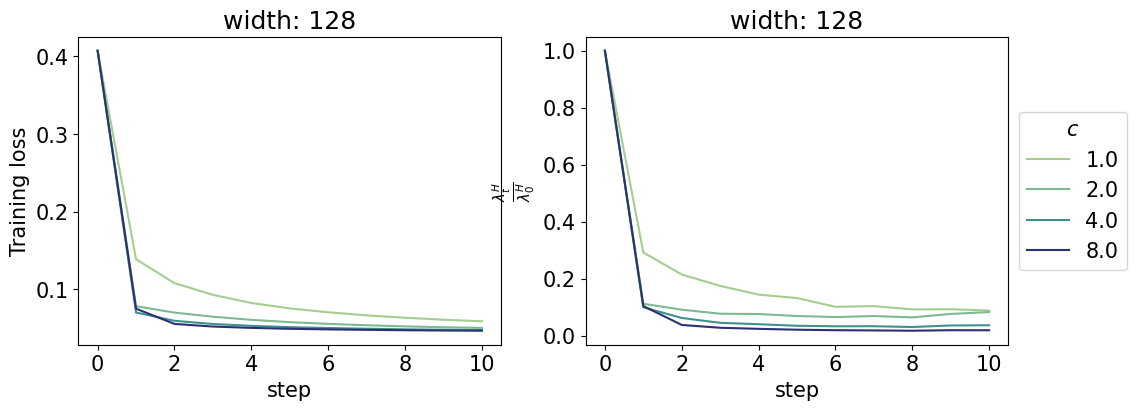

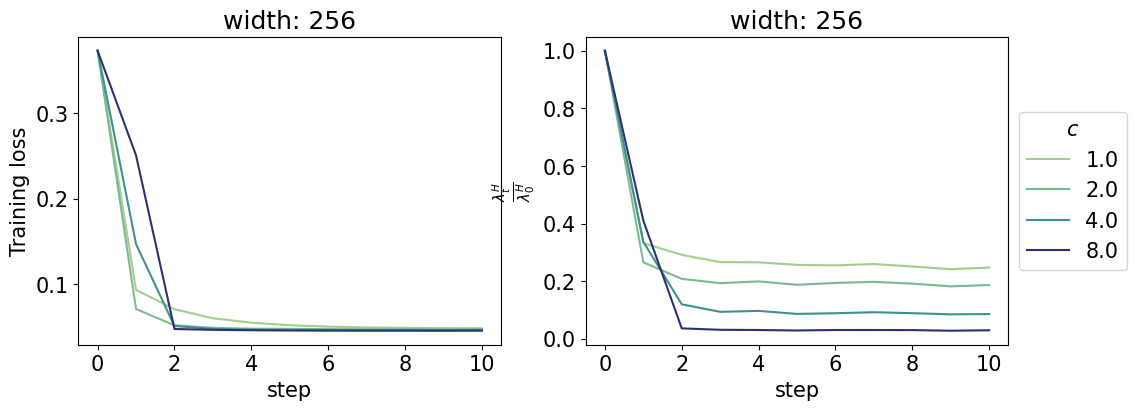

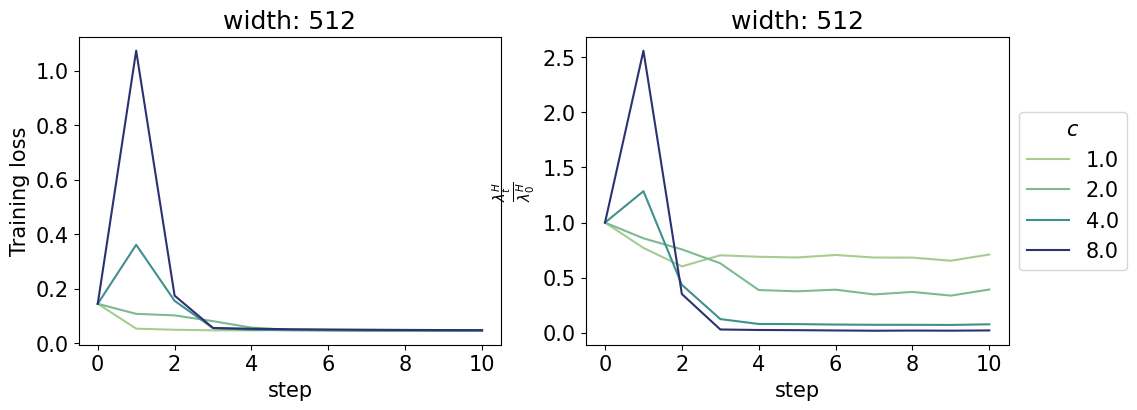

In [12]:
lr_plot = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
dfs['lr_exp'] = dfs['lr_exp'].round(1)
dfs['lr_const'] = dfs['lr_const'].round(1)

df_plot = get_rows_where_col_in(dfs, 'lr_exp', lr_plot)
print(df_plot['lr_exp'].unique())

for i, width in enumerate(widths):
    
    df_width = get_rows_where_col_equals(df_plot, 'width', width)

    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    ax = axes[0]
    ax = sns.lineplot(x = 'step', y = 'train_loss_step', data = df_width, hue = 'lr_const', palette = 'crest', legend = 'full', ax = ax)
    ax.set_xlabel('step')
    ax.set_ylabel(r'Training loss')
    ax.set_title(f'width: {width}')
    ax.get_legend().remove()

    ax = axes[1]
    ax = sns.lineplot(x = 'step', y = 'norm_sharp', data = df_width, hue = 'lr_const', palette = 'crest', legend = 'full', ax = ax)
    ax.set_xlabel('step')
    ax.set_ylabel(r'$\frac{\lambda_t^H}{\lambda_0^H}$')
    ax.set_title(f'width: {width}')
    ax.legend(title = r'$c$', loc='center left', bbox_to_anchor=(1, 0.5))


### Estimate critical constants

In [13]:
# note: For zero initialized networks, sharpness does not decrease appreciably during early training. 
# To avoid random fluctuations in sharpness to be considered as sharpness catapult, we compare the normalized sharpness with 1+epsilon to define sharpness catapult.

epsilon = 0.05

#estimate c_loss
df_filtered = dfs[dfs['norm_loss'] > 1.0]
df_grouped = df_filtered.groupby('width')['lr_const'].min()
df_closs = df_grouped.reset_index().astype(float)
df_closs['1w'] = 1 / df_closs['width']

#estimate c_sharp
df_filtered = dfs[dfs['norm_sharp'] > 1 + epsilon]
df_grouped = df_filtered.groupby('width')['lr_const'].min()
df_csharp = df_grouped.reset_index().astype(float)
df_csharp['1w'] = 1 / df_csharp['width']

#estimate c_max
df_grouped = dfs.groupby('width')['lr_const'].max()
df_cmax = df_grouped.reset_index().astype(float)
df_cmax['1w'] = 1 / df_cmax['width']



### Plot the phase diagram

(np.float64(0.0018223300615953274), np.float64(0.008088007217510936))

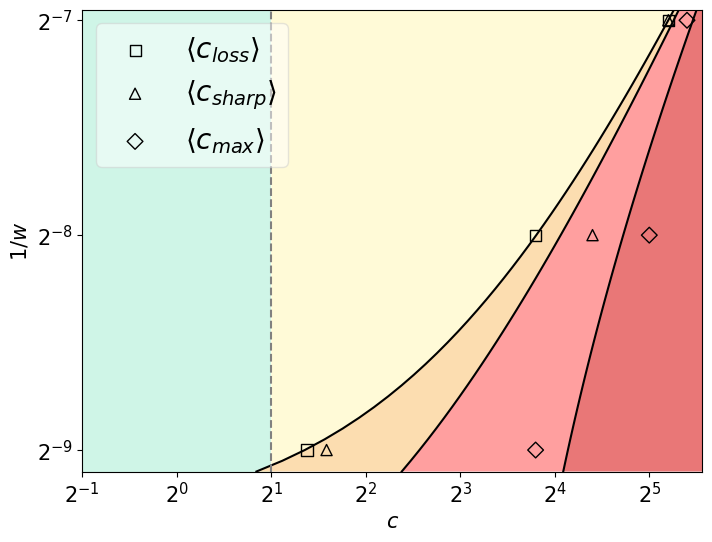

In [14]:
order = 1 #order of curve to fit
# for this phase diagram order 1 works better

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
colors = sns.color_palette('tab10', 3)

ax.scatter('lr_const', '1w', data = df_closs, marker = 's', color = 'black', label = r'$\langle c_{loss} \rangle$', facecolors = 'none', zorder = 2, s = 64)
ax.scatter('lr_const', '1w', data = df_csharp, marker = '^', color = 'black', label = r'$\langle c_{sharp} \rangle$', facecolors = 'none', zorder = 2, s = 64)
ax.scatter('lr_const', '1w', data = df_cmax, marker = 'D', color = 'black', label = r'$\langle c_{max} \rangle$', facecolors = 'none', zorder = 2, s = 64)

# fit curves
y = df_closs['1w'].values

ymin = np.min(y)
ymax = np.max(y)

y_new = np.array([2**i for i in np.arange(np.log2(ymin) - 0.1, np.log2(ymax) + 0.1, 0.05)])

x = df_closs['lr_const'].values
coeffs = np.polyfit(y, x, order)
smooth_loss = poly(coeffs, y_new)
ax.plot(smooth_loss, y_new, '-', color = 'black')

x = df_csharp['lr_const'].values
coeffs = np.polyfit(y, x, order)
smooth_sharp = poly(coeffs, y_new)
ax.plot(smooth_sharp, y_new, '-', color = 'black')


x = df_cmax['lr_const'].values
coeffs = np.polyfit(y, x, order)
smooth_max = poly(coeffs, y_new)
ax.plot(smooth_max, y_new, '-', color = 'black')

x_max = np.max(x) + 5

#Fill colors
y1 = 0.0*np.ones(len(y_new))
y2 = 2*np.ones(len(y_new))
ax.fill(np.append(y1, y2[::-1]), np.append(y_new, y_new[::-1]), '#CFF5E7')

y1 = 2*np.ones(len(y_new))
y2 = smooth_loss
ax.fill(np.append(y1, y2[::-1]), np.append(y_new, y_new[::-1]), '#FFFAD7')

y1 = smooth_loss
y2 = smooth_sharp
ax.fill(np.append(y1, y2[::-1]), np.append(y_new, y_new[::-1]), '#FCDDB0')

y1 = smooth_sharp
y2 = smooth_max
ax.fill(np.append(y1, y2[::-1]), np.append(y_new, y_new[::-1]), '#FF9F9F')

y1 = smooth_max
y2 = x_max*np.ones(len(y_new))
ax.fill(np.append(y1, y2[::-1]), np.append(y_new, y_new[::-1]), '#E97777')


ax.axvline(x = 2.0, linestyle = '--', color = 'gray')
ax.set_xscale('log', base = 2)
ax.set_yscale('log', base = 2)
ax.legend(fontsize = 20, loc='upper left', facecolor = 'white', framealpha = 0.5)
ax.set_ylabel(r'$1/w$')
ax.set_xlabel(r'$c$')
ax.set_xlim(0.5, x_max)
ax.set_ylim(y_new[0], y_new[-1])



Key results: 


*   critical constants $c_{loss}, c_{sharp}$ do not scale with $1 / w$
*   $c_{loss} = 2$ independent of depth and width.